In [14]:
import laytr
import joblib
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
sb.set_style(rc={"pdf.fonttype": 42})

In [2]:
som = joblib.load("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/adotto_TRv1.1_4mers.som")
s_map = joblib.load("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/adotto_TRv1.1_4mers.map")

In [15]:
benchmark = pd.read_csv("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/GIABTR.HG002.benchmark.regions.bed.gz",
                        sep='\t', names=['chrom', 'start', 'end', 'tier', 'repl', 'var_state', 'entropy', 'mat_ad', 'pat_ad'])
benchmark.set_index(['chrom', 'start', 'end'], inplace=True)

In [4]:
s_map_df = pd.DataFrame(s_map['map'], columns=["som_X", "som_Y"], 
                        index=pd.MultiIndex.from_tuples(s_map['index'], names=["chrom", "start", "end"]))

In [5]:
data = benchmark.join(s_map_df)

In [6]:
data.head()

tier      repl  var_state   entropy  mat_ad  pat_ad  \
chrom start  end                                                            
chr1  839177 839680  Tier1  TP_TP_TP         15  0.888568      42      42   
      840404 840466  Tier1  TN_TN_TN         14  0.765189       1       1   
      841888 841965  Tier1  TN_TN_TN          8  0.975809       0       0   
      844335 844427  Tier1  TN_TN_TN          8  0.997269       0       0   
      850622 850687  Tier1  TN_TN_TN         12  0.825237       0       0   

                     som_X  som_Y  
chrom start  end                   
chr1  839177 839680      3     22  
      840404 840466      3      0  
      841888 841965     10      1  
      844335 844427     10     22  
      850622 850687      4      7

In [7]:
total_neuron_count = s_map_df.groupby(['som_X', 'som_Y']).size()

In [8]:
benchmark_neuron_count = data.groupby(['som_X', 'som_Y']).size()

In [9]:
pct_of_neurons = benchmark_neuron_count / total_neuron_count

<Axes: >

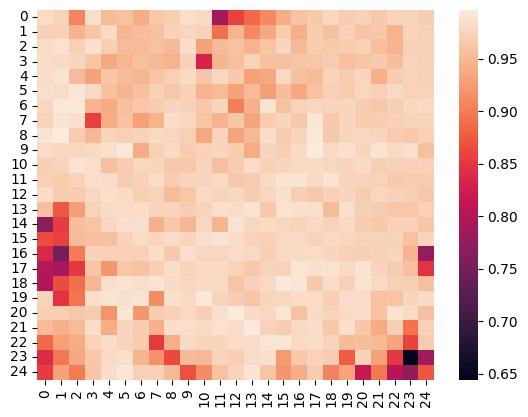

In [10]:
sb.heatmap(np.flip(pct_of_neurons.unstack().values.T))

In [11]:
(pct_of_neurons * 100).mean(), (pct_of_neurons * 100).std()

(95.97210526676689, 3.820627869623797)

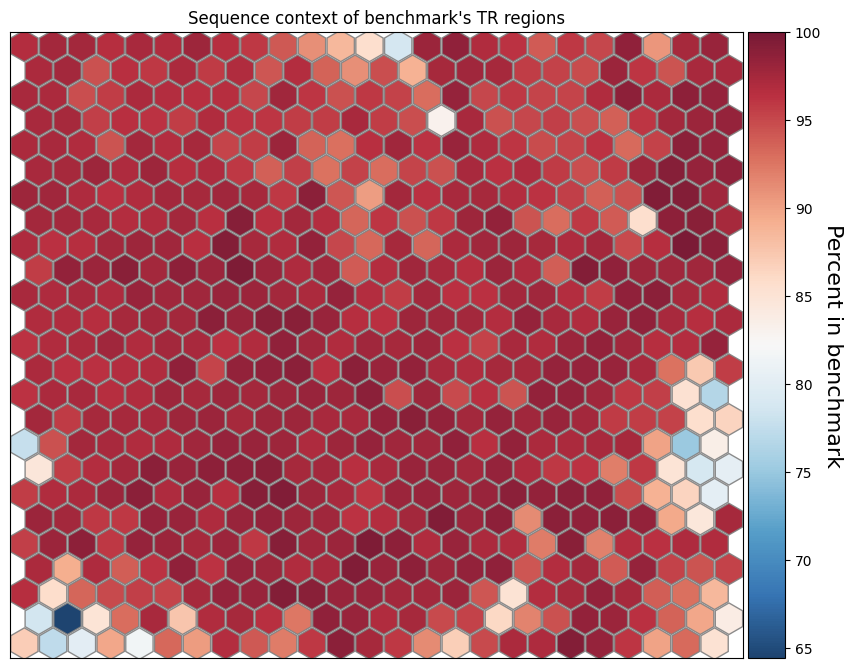

In [13]:
v = pct_of_neurons.unstack().values * 100
norm = colors.Normalize(vmin=v.min(), vmax=100)
p = laytr.make_hex_plot(som,
                       hue=v,
                       hue_label="Percent in benchmark", 
                       color_map=cm.RdBu_r,
                       color_norm=norm,
                       alpha=0.9)
p.axes[0].set_title("Sequence context of benchmark's TR regions")
plt.xticks(ticks=None, labels=None)
plt.yticks(ticks=None, labels=None)
p.axes[0].get_xaxis().set_visible(False)
p.axes[0].get_yaxis().set_visible(False)
plt.savefig("Figure2B.pdf")

In [5]:
# Seg dup and long homopolymerr 'deficient'

- making sure the 15% threshold is good
- plotting the pct captured regions per neuron
- Groupby som_X/som_Y - pct_hom.mean()
- kdeplot confirm 15% is good enough


In [9]:
catalog = (pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.1.bed", sep='\t')
           .rename(columns={'chr':'chrom'})
           .set_index(['chrom', 'start', 'end']))

In [10]:
catalog = catalog.join(s_map_df)

In [13]:
view = catalog.groupby(['som_X', 'som_Y'])['hom_pct'].mean()

<Axes: xlabel='hom_pct', ylabel='Count'>

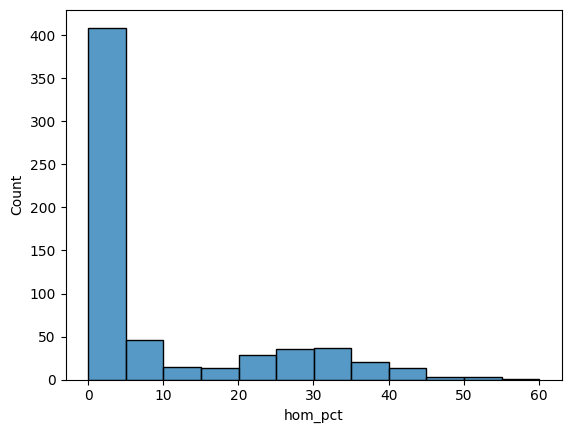

In [15]:
sb.histplot(data=view, binwidth=5)

In [18]:
catalog['is_benchmark'] = catalog.index.isin(benchmark.index)

In [27]:
tot = catalog.groupby(['som_X', 'som_Y']).size()
pct_hom = catalog.groupby(['som_X', 'som_Y'])['hom_pct'].mean()
m_view = catalog[catalog['is_benchmark']].groupby(['som_X', 'som_Y']).size()
m_view = m_view.rename("benchmark_count").to_frame()
m_view['total'] = tot
m_view['mean_hom_pct'] = pct_hom
m_view

benchmark_count  total  mean_hom_pct
som_X som_Y                                      
0     0                 1956   2248     45.973310
      1                 2063   2628     44.582192
      2                  827    856     30.949766
      3                 1245   1281     31.973458
      4                 1438   1505     32.486379
...                      ...    ...           ...
24    20                4706   4787      0.460414
      21                1952   1986      0.101208
      22                7624   7761      1.990594
      23                3862   3972      2.445116
      24                2530   2577      1.882421

[625 rows x 3 columns]

In [38]:
m_view['≥15% Homopolymer'] = m_view['mean_hom_pct'] >= 15
m_view['pct_captured'] = m_view['benchmark_count'] / m_view['total']

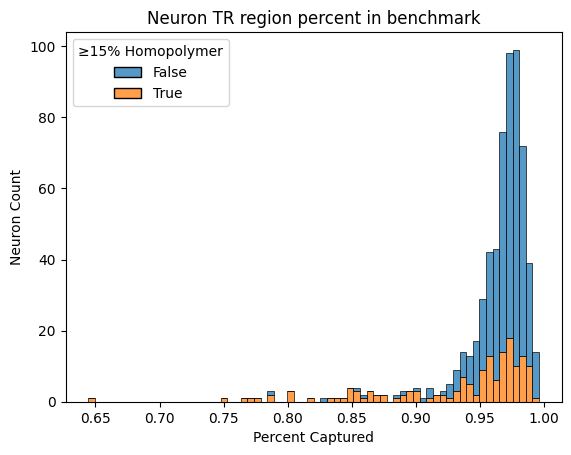

In [39]:
p = sb.histplot(data=m_view, x="pct_captured", hue="≥15% Homopolymer", multiple='stack')
p.set(title="Neuron TR region percent in benchmark", xlabel="Percent Captured", ylabel="Neuron Count")
plt.savefig("sup_NeuronHomPolyDefic.pdf")

In [31]:
catalog[catalog['hom_pct'] >= 15]['is_benchmark'].value_counts()

True     429694
False     33543
Name: is_benchmark, dtype: int64

In [37]:
# still include N% of their TRs in the benchmark 
print(429694 / (429694+33543))

0.9275899809384829


<Axes: xlabel='mean_hom_pct', ylabel='Count'>

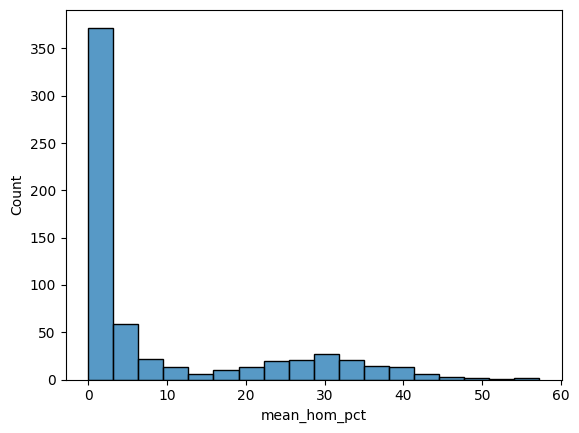

In [32]:
sb.histplot(data=m_view, x="mean_hom_pct")

In [35]:
catalog.groupby(['is_benchmark'])['hom_pct'].describe().T

is_benchmark,False,True
count,77951.000000,1.706853e+06
mean,18.803274,9.233591e+00
std,20.634456,1.497309e+01
min,0.000000,0.000000e+00
25%,0.000000,0.000000e+00
50%,9.000000,0.000000e+00
75%,39.000000,1.500000e+01
max,100.000000,1.000000e+02


# Properties of Tier2

In [16]:
benchmark.head()

tier      repl  var_state   entropy  mat_ad  pat_ad
chrom start  end                                                         
chr1  839177 839680  Tier1  TP_TP_TP         15  0.888568      42      42
      840404 840466  Tier1  TN_TN_TN         14  0.765189       1       1
      841888 841965  Tier1  TN_TN_TN          8  0.975809       0       0
      844335 844427  Tier1  TN_TN_TN          8  0.997269       0       0
      850622 850687  Tier1  TN_TN_TN         12  0.825237       0       0

In [32]:
v = benchmark[benchmark['tier'] == 'Tier2']['repl'].value_counts()

In [35]:
v = v.sort_values(ascending=False)

In [ ]:
v = v.to_frame()


,repl
__TN,63671
TN_TN_TP,620
__TP,513
FP_FP_TN,371
TP_FP_TP,345
...,...
"FP_TP_FN,FP",1
"FN_TP_FN,FP",1
FP_TN_FP,1
FN_TP_FN,1


In [38]:
v['pct'] = v['repl'] / v['repl'].sum()
v

,repl,pct
__TN,63671,0.931612
TN_TN_TP,620,0.009072
__TP,513,0.007506
FP_FP_TN,371,0.005428
TP_FP_TP,345,0.005048
...,...,...
"FP_TP_FN,FP",1,0.000015
"FN_TP_FN,FP",1,0.000015
FP_TN_FP,1,0.000015
FN_TP_FN,1,0.000015
